In [1]:
from pathlib import Path
import os
from multiprocessing import cpu_count
import json
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import igraph as ig
import copy

import torch

from pytorch_lightning import Trainer, seed_everything

from libraries.lightningDMBACNN import ImageFolderLightningDataModule, WhoiDataModule, ZooscanDataModule, LenslessDataModule, ZooLakeDataModule
from libraries.helper_functions import class_histogram, sample_images

/home/jhimbert/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plankton_dataset = {
        '1': ['WHOI',       WhoiDataModule,     "whoi_dictionary.pkl"],           
        '2': ['Zooscan',    ZooscanDataModule,  "zs_dictionary.pkl"],  # 93 taxa classes and 1,433,278 images taken from EcoTaxa
        '3': ['Lensless',   LenslessDataModule, "ll_dictionary.pkl"],
        '4': ['Zoolake',    ZooLakeDataModule,  "zl_dictionary.pkl"], 
    }

""" Change the number in the brackets for the dataset you want to use """
dataset = plankton_dataset['2']



In [3]:
dataset_name = dataset[0]
image_folder = dataset_name + '_hierarchical_imagefolder'
img_size = 224

In [4]:
# Set directory for dataset

DATA_DIR = Path.cwd().parent / "data"
DATA_DIR.mkdir(exist_ok=True)
DATASET_DIR = DATA_DIR / image_folder

# Set location of Mean and Standard deviation and class dictionary

LIB_DIR = Path.cwd() / 'libraries'
SAVED_MEAN_AND_STD = LIB_DIR / 'saved_mean_std'
SAVED_MEAN_AND_STD.mkdir(exist_ok=True)
saved_mean_std = f"{dataset_name}_mean_std_{img_size}.pt"
MEAN_STD_PATH = Path(SAVED_MEAN_AND_STD) / saved_mean_std

In [5]:
datamodule = dataset[1](DATA_DIR)

#datamodule.prepare_data(force_download=False) # Change to True to force download

datamodule = ImageFolderLightningDataModule(data_dir=DATASET_DIR, mean_std_path=MEAN_STD_PATH)

datamodule.setup()

num_classes = datamodule.num_classes

In [30]:
NUM_CLASSES = [2, 13, 93]

# NetworkX graph

In [41]:
def create_networkX_graph(root_dir=DATASET_DIR):
    subset_colors = [
    # first layer
    "red","green",
    # second layer
    "orangered","tomato","coral","lightsalmon",
    
    "chartreuse","palegreen","lightgreen","limegreen","forestgreen","green","darkgreen","mediumseagreen","mediumaquamarine",
    # third layer
    "orangered","tomato","coral","lightsalmon",
    
    "chartreuse","palegreen","lightgreen","limegreen","forestgreen","green","darkgreen","mediumseagreen","mediumaquamarine",
    ]
    
    G=nx.Graph()
    first_level_classes = sorted(os.listdir(root_dir))
    for i, first_level_class in enumerate(first_level_classes):
        G.add_node(i, name=first_level_class, layer=2, color=subset_colors[i])

    second_level_tot = []
    for i, first_level_class in enumerate(first_level_classes):
        second_level_classes = sorted(os.listdir(os.path.join(root_dir, first_level_class)))
        second_level_tot = second_level_tot + second_level_classes
    for j, second_level_class in enumerate(second_level_tot):
        G.add_node(j + NUM_CLASSES[0], name=second_level_class, layer=1, color=subset_colors[j + NUM_CLASSES[0]])
    
    third_level_tot = []
    color_third = []
    for i, first_level_class in enumerate(first_level_classes):
        second_level_classes = sorted(os.listdir(os.path.join(root_dir, first_level_class)))
        for j, second_level_class in enumerate(second_level_classes):
            third_level_classes = sorted(os.listdir(os.path.join(root_dir, first_level_class, second_level_class)))
            third_level_tot = third_level_tot + third_level_classes
            if i == 0:
                color_third = color_third + [subset_colors[j + NUM_CLASSES[0]]]*len(third_level_classes)
            else:
                color_third = color_third + [subset_colors[j + NUM_CLASSES[0] + 4]]*len(third_level_classes)
    for k, third_level_class in enumerate(third_level_tot):
        G.add_node(k + NUM_CLASSES[0] + NUM_CLASSES[1], name=third_level_class, layer=0, color=color_third[k])

    return G

def add_edges_NetworkX(G, RESULTS_DIR):
    c_pred_1 = torch.load(RESULTS_DIR / 'c_pred_1_test.pt')
    c_pred_2 = torch.load(RESULTS_DIR / 'c_pred_2_test.pt')
    c_pred_3 = torch.load(RESULTS_DIR / 'c_pred_3_test.pt')
    
    if len(c_pred_1.size()) == 2:
        c_pred_1 = torch.argmax(c_pred_1, dim=1)
        c_pred_2 = torch.argmax(c_pred_2, dim=1)
        c_pred_3 = torch.argmax(c_pred_3, dim=1)
    
    NUM_CLASSES = [2, 13, 93]
    length = len(c_pred_1)
    
    for i in range(length):
        val1 = int(c_pred_1[i])
        val2 = int(c_pred_2[i] + NUM_CLASSES[0])
        val3 = int(c_pred_3[i] + NUM_CLASSES [0] + NUM_CLASSES[1])
        if not G.has_edge(val1, val2):
            G.add_edge(val1, val2, weight=1)
        else:
            G[val1][val2]['weight'] += 1
        if not G.has_edge(val2, val3):
            G.add_edge(val2, val3, weight=1)
        else:
            G[val2][val3]['weight'] += 1
    
    return G

def add_edges_NetworkX_Normalized(G, RESULTS_DIR):
    c_pred_1 = torch.load(RESULTS_DIR / 'c_pred_1_test.pt')
    c_pred_2 = torch.load(RESULTS_DIR / 'c_pred_2_test.pt')
    c_pred_3 = torch.load(RESULTS_DIR / 'c_pred_3_test.pt')
    
    if len(c_pred_1.size()) == 2:
        c_pred_1 = torch.argmax(c_pred_1, dim=1)
        c_pred_2 = torch.argmax(c_pred_2, dim=1)
        c_pred_3 = torch.argmax(c_pred_3, dim=1)
    
    c_true = torch.load(RESULTS_DIR / 'c_true_test.pt')
    c_true_1 = c_true[:, 0]
    c_true_2 = c_true[:, 1]
    c_true_3 = c_true[:, 2]
    
    normalizer = {}
    length = len(c_pred_1)
    
    for i in range(length):
        val1 = int(c_pred_1[i])
        val2 = int(c_pred_2[i] + NUM_CLASSES[0])
        val3 = int(c_pred_3[i] + NUM_CLASSES [0] + NUM_CLASSES[1])
        
        ct1 = int(c_true_1[i])
        ct2 = int(c_true_2[i]+ NUM_CLASSES[0])
        ct3 = int(c_true_3[i]+ NUM_CLASSES [0] + NUM_CLASSES[1])
        
        normalizer[ct1] = normalizer.get(ct1, 0) + 1
        normalizer[ct2] = normalizer.get(ct2, 0) + 1
        normalizer[ct3] = normalizer.get(ct3, 0) + 1
        
        if not G.has_edge(val1, val2):
            G.add_edge(val1, val2, weight=1)
        else:
            G[val1][val2]['weight'] += 1
        if not G.has_edge(val2, val3):
            G.add_edge(val2, val3, weight=1)
        else:
            G[val2][val3]['weight'] += 1
            
    for u, v, data in G.edges(data=True):
        G[u][v]['weight'] /= (1 + normalizer.get(v, 0))
    
    return G

In [42]:
def pos_update(pos, G):
    T = {}
    new_pos = {}
    factor = []
    list_of_colors = ["orangered","tomato","coral","lightsalmon","chartreuse","palegreen","lightgreen","limegreen","forestgreen","green","darkgreen","mediumseagreen","mediumaquamarine"]
    number_of_nodes = {i: 0 for i in list_of_colors}
    color_mean_position = {color: np.array([0., 0.]) for color in list_of_colors}
    
    # calculate mean position
    for p in pos.keys():
        if G.nodes[p]['layer'] == 0:
            color = G.nodes[p]['color']
            color_mean_position[color] += pos[p]
            number_of_nodes[color] += 1
    for color in color_mean_position.keys():
        color_mean_position[color] /= number_of_nodes[color]
        T[color] = 0.1 + 0.5/number_of_nodes[color]
            
    for p in pos.keys():
        data = G.nodes[p]
        layer = data['layer']
        if p == 0 or p == 1: # layer == 2
            x, y = pos[p]
            new_pos[p] = np.array([x*10, y])
        elif layer == 1:
            x, y = pos[p]
            new_pos[p] = np.array([x * 7, y])
        else: # layer == 0
            x, y = pos[p]
            color = data['color']
            mx, my = color_mean_position[color]
            t = T[color]
            new_pos[p] = np.array([mx*t + (1-t)*x, y])
    return new_pos
        

In [43]:
def show_graph(G, save_fig=False, title='', regularisation='sqrt', factor=100):
    NUM_CLASSES = [2, 13, 93]
    subset_sizes = NUM_CLASSES


    colors = []
    for v, data in G.nodes(data=True):
        colors.append(data['color'])

    lines_width = []
    for u, v, data in G.edges(data=True):
        lines_width.append(G[u][v]['weight'])

    lines_width = torch.Tensor(lines_width)
    if regularisation == 'log':
        lines_width = torch.log(lines_width)/factor
    elif regularisation == 'sqrt':
        lines_width = torch.sqrt(lines_width)/factor
    lines_width = lines_width.tolist()


    nodes_labels = {v: data['name'] if v < 15 else '' for v, data in G.nodes(data=True)}
    nodes_labels[11] = 'CYPHONAUTE'

    pos = nx.multipartite_layout(G,
                                 subset_key="layer",
                                 align='horizontal',
                                 scale=1.0,
                                 #center=[1, 1],
                                )

    pos = pos_update(pos, G)

    plt.figure(figsize=(30, 10))
    nx.draw(G,
            pos,
            node_color=colors,
            with_labels=True,
            arrows=True,
            arrowstyle='-|>',
            arrowsize=10,
            alpha=0.8,
            #linewidths=1.0,
            width=lines_width,
            edge_color='k',
            labels=nodes_labels,
            font_size=12,
            font_weight='heavy',
            label='Graph Label',
            #bbox=,
            horizontalalignment='center',
            verticalalignment='bottom',
           )
    #plt.axis("equal")
    if save_fig:
        plt.savefig(title)
    plt.show()

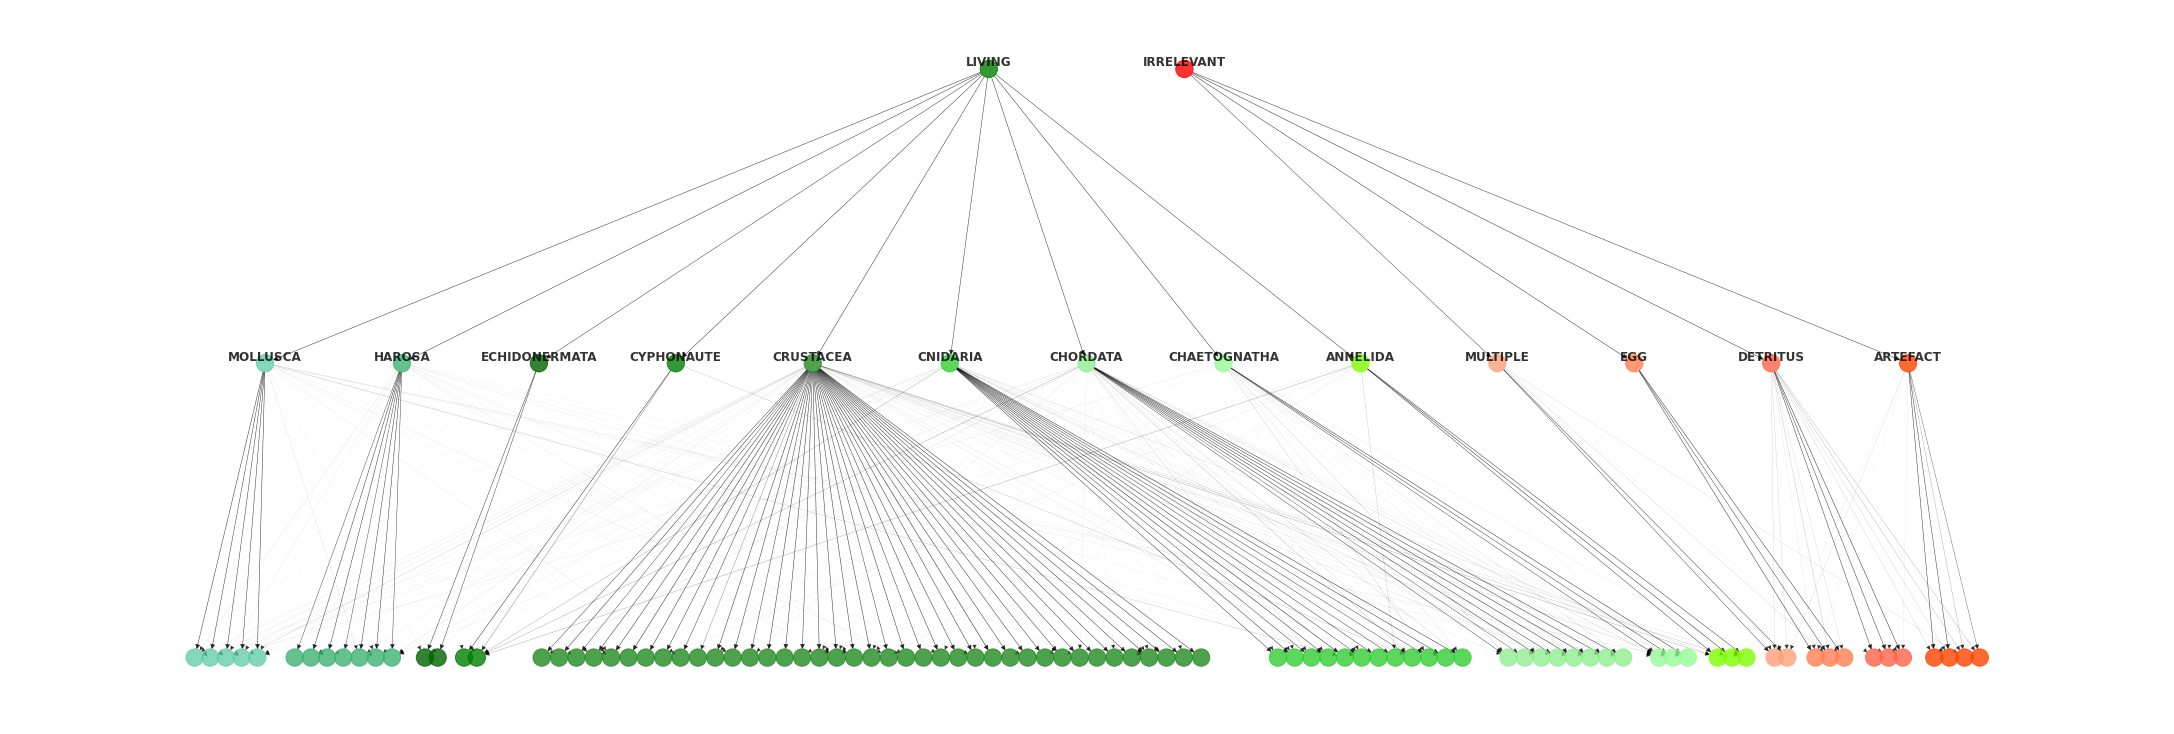

In [44]:
G = create_networkX_graph(DATASET_DIR)
G = add_edges_NetworkX_Normalized(G, Path.cwd()/'experiments_folder/test_hierar_Zooscan_v6_storage/results')
show_graph(G, save_fig=False, title='TreeBACNN_N.png', regularisation='sqrt', factor=2)

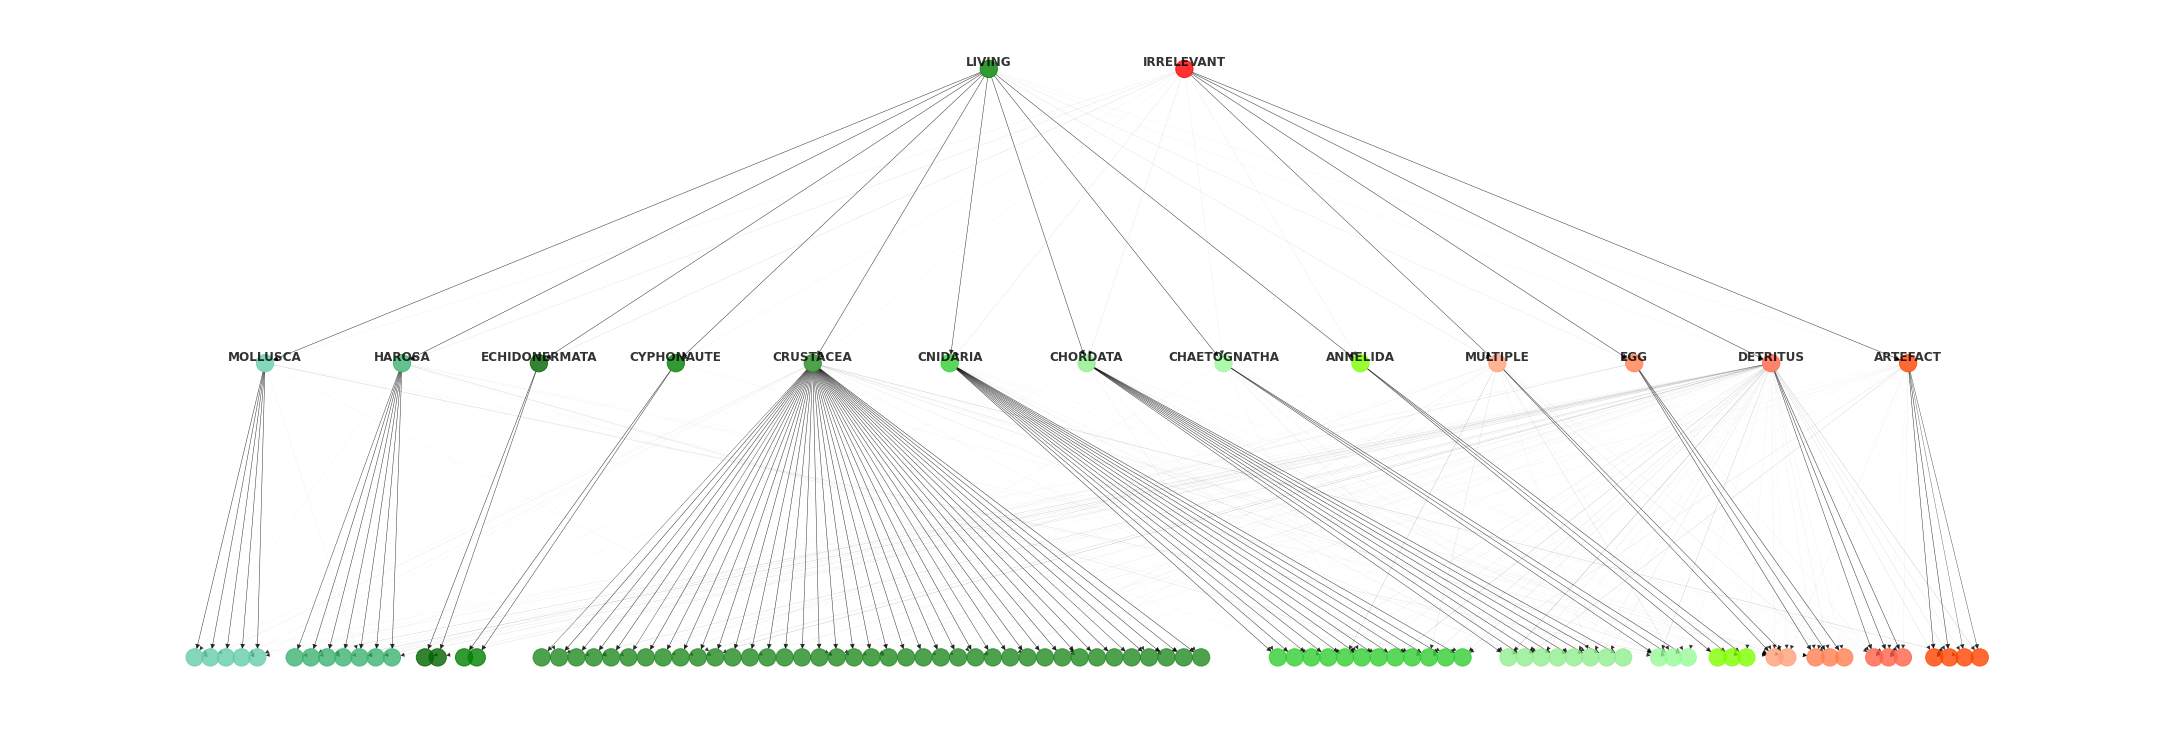

In [47]:
G = create_networkX_graph(DATASET_DIR)
G = add_edges_NetworkX_Normalized(G, Path.cwd()/'experiments_folder/test_BACNN_Zooscan_v2/results')
show_graph(G, save_fig=False, title='TreeBACNN_N.png', regularisation='sqrt', factor=2)

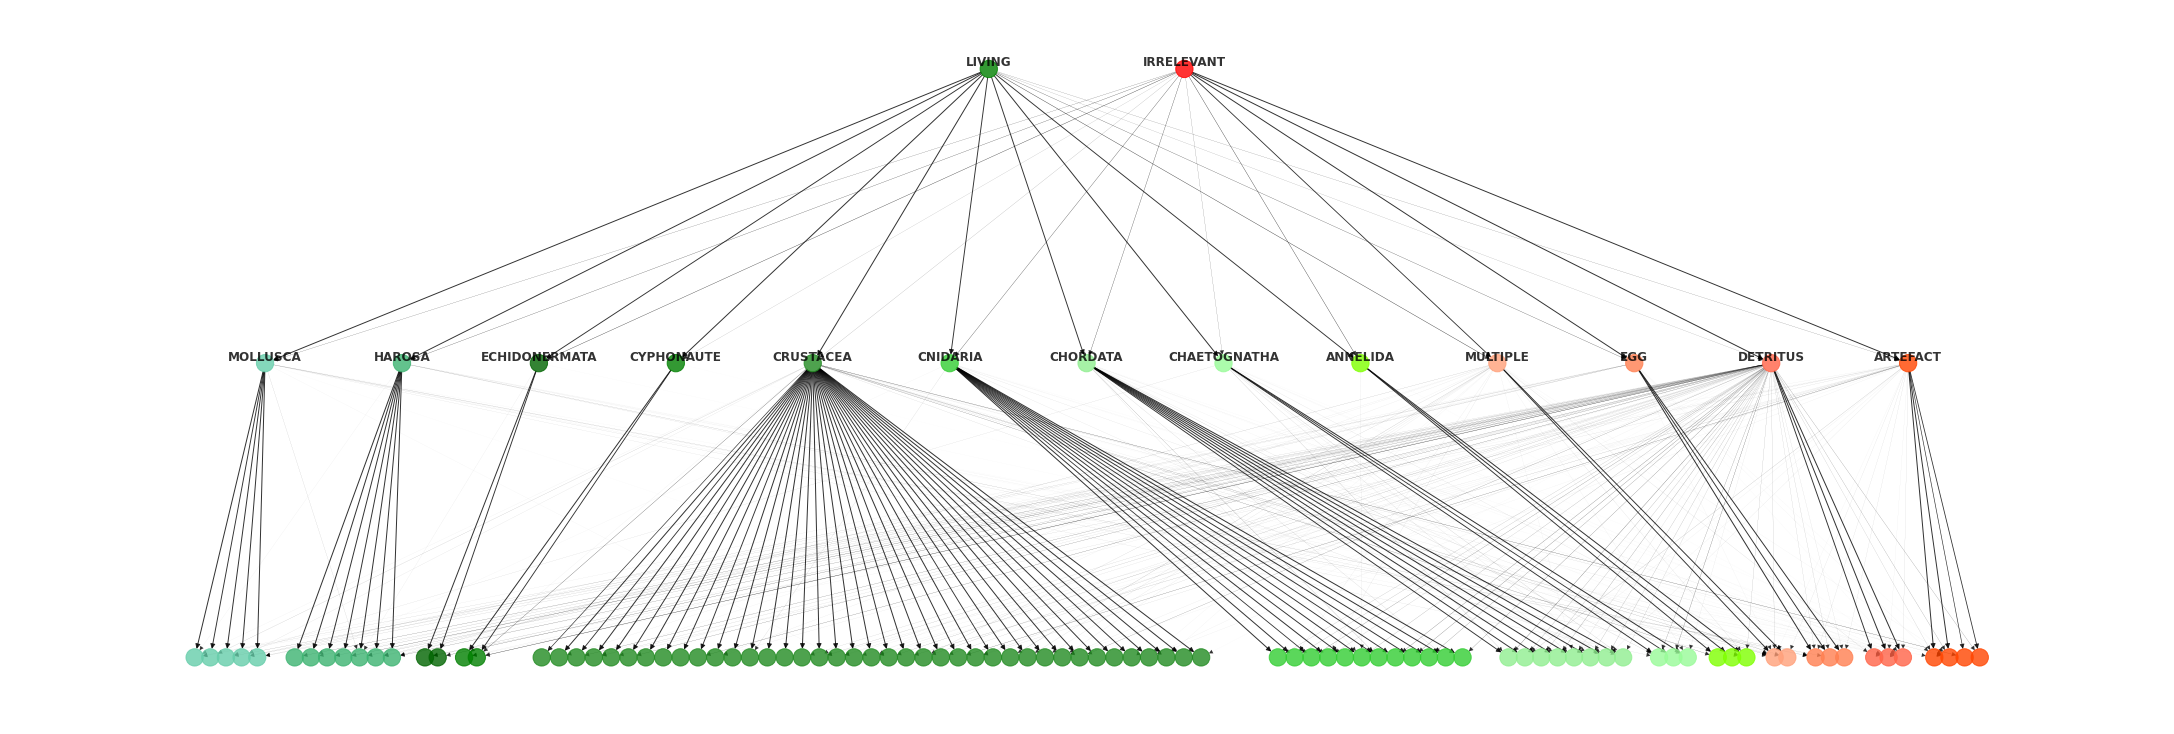

In [45]:
H = create_networkX_graph(DATASET_DIR)
H = add_edges_NetworkX_Normalized(H, Path.cwd()/'experiments_folder/test_HBilinear_Zooscan_v1/results')
show_graph(H, save_fig=False, title='TreeHBilinear_N.png', regularisation='sqrt', factor=1)

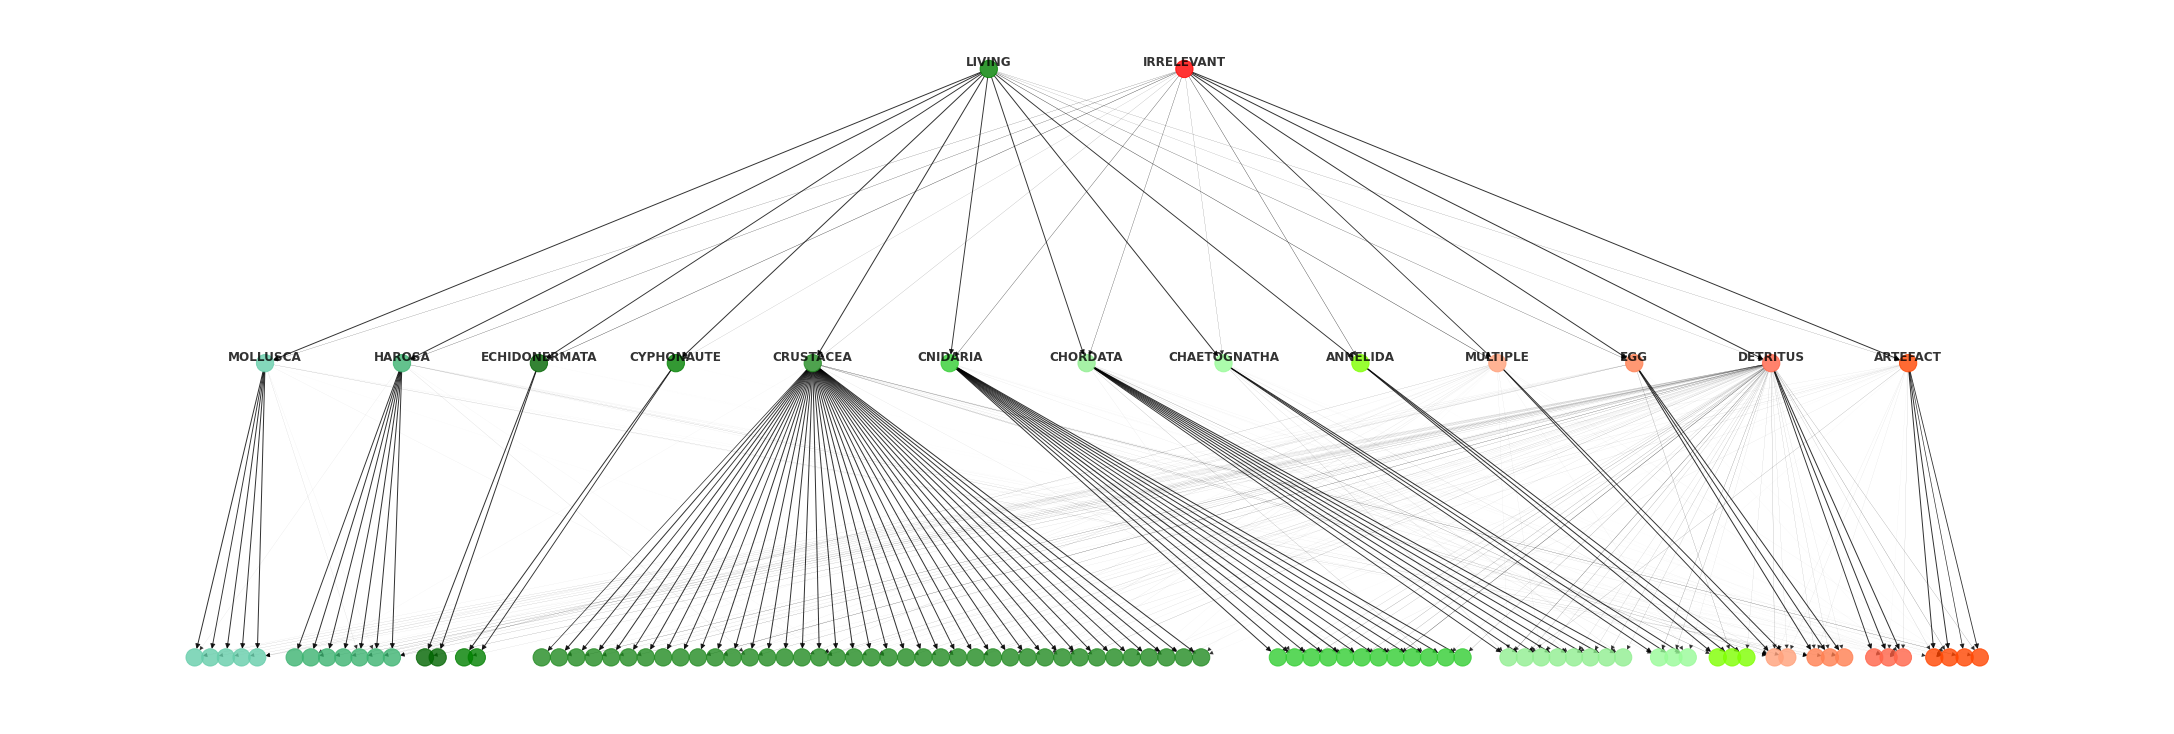

In [46]:
K = create_networkX_graph(DATASET_DIR)
K = add_edges_NetworkX_Normalized(K, Path.cwd()/'experiments_folder/basic_BCNN_Zooscan_v1/results')
show_graph(K, save_fig=False, title='TreeBCNN_N.png', regularisation='sqrt', factor=1)